# Verifying Parent Hamiltonians Across State Complexity and Projector Locality

## Overview
This notebook runs a large-scale computational experiment to test the parent Hamiltonian principle under various conditions. The claim is that a generic MPS-like state `|psi_initial>` is the unique ground state of the Hamiltonian `H` constructed from its own local properties.

We investigate how the fidelity between `|psi_initial>` and the calculated ground state `|psi_GS>` depends on:
1.  **Initial State Complexity:** Controlled by `PSI_ANSATZ_DEPTH` (from 1 to 5).
2.  **Projector Locality/Complexity:** Controlled by `PROJECTOR_QUBIT_COUNT` (from 2 to 5).

For each configuration, the projector rank is set to be half the dimension of the local subspace ($2^{N_p-1}$), and the unitary complexity (`PROJECTOR_U_REPS`) scales with the projector size.

## 1. Imports and Setup

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, state_fidelity
import itertools 
import matplotlib.pyplot as plt
import time

try:
    from scipy.optimize import minimize
except ModuleNotFoundError:
    print("ERROR: scipy is not installed. Please install it: pip install scipy")
    def minimize(*args, **kwargs):
        raise RuntimeError("scipy.optimize.minimize not found. Please install scipy.")

## 2. Experiment Configuration
**WARNING:** This is a computationally intensive experiment. The runtime will increase significantly with `NUM_QUBITS`, `MAX_ANSATZ_DEPTH`, and `PROJECTOR_QUBITS_TO_TEST`. For initial tests, consider reducing `NUM_RUNS_PER_CONFIG` to 1 or lowering `SCIPY_COBYLA_MAXITER`.

In [2]:
# --- Main Experiment Configuration ---
NUM_QUBITS = 8
PROJECTOR_QUBITS_TO_TEST = [2, 3, 4, 5]
MAX_ANSATZ_DEPTH = 5
NUM_RUNS_PER_CONFIG = 3 # Number of random instances to average per data point

# --- Optimizer Configuration ---
SCIPY_COBYLA_MAXITER = 2000 # Keep this reasonable for speed
SCIPY_COBYLA_TOL = 1e-4     # Looser tolerance for speed
MAIN_SEED = 42

np.random.seed(MAIN_SEED)
print(f"Main NumPy random seed for experiment: {MAIN_SEED}")

Main NumPy random seed for experiment: 42


## 3. Core Logic Function
This function encapsulates the process for a single experimental run: one state, one projector configuration, one seed.

In [5]:
def run_parent_hamiltonian_test(num_qubits, psi_depth, proj_qubit_count, proj_rank, proj_u_reps, run_seed):
    """Runs one instance of the parent Hamiltonian test and returns the final fidelity."""
    np.random.seed(run_seed)
    
    # --- 1. Create Reference State ---
    psi_ansatz = RealAmplitudes(num_qubits, reps=psi_depth, entanglement='linear')
    if psi_ansatz.num_parameters > 0:
        psi_params = np.random.rand(psi_ansatz.num_parameters) * 2 * np.pi
        psi_circuit = psi_ansatz.assign_parameters(psi_params)
    else: # Handles depth=0 case
        psi_circuit = QuantumCircuit(num_qubits)
        
    try:
        psi_initial_vector = Statevector(psi_circuit)
    except Exception:
        return np.nan

    # --- 2. Define and Optimize Projectors ---
    qubit_groups = [tuple((i + j) % num_qubits for j in range(proj_qubit_count)) for i in range(num_qubits)]
    u_ansatz = TwoLocal(proj_qubit_count, ['ry', 'rz'], 'cx', 'linear', reps=proj_u_reps)
    num_u_params = u_ansatz.num_parameters
    
    optimized_projectors = []
    for q_group in qubit_groups:
        # --- CORRECTED BASE PROJECTOR CONSTRUCTION ---
        # Start with an empty (zero) operator on the full number of qubits
        total_base_proj_op = SparsePauliOp("I" * num_qubits, coeffs=[0])

        # Sum the projectors for the first `proj_rank` computational basis states
        for i in range(proj_rank):
            # Get the binary string for the integer i, e.g., '001' for i=1, N_p=3
            basis_state_str = format(i, f'0{proj_qubit_count}b')
            
            # The projector |i><i| = product_k( |i_k><i_k| )
            # where |0><0| = (I+Z)/2 and |1><1| = (I-Z)/2
            # The full expansion has 2^proj_qubit_count Pauli terms.
            for pauli_choices in itertools.product(['I', 'Z'], repeat=proj_qubit_count):
                pauli_str_list = ['I'] * num_qubits
                coeff = 1.0 / (2**proj_qubit_count) # Start with the overall coefficient

                # Determine the Pauli string and coefficient for this term in the expansion
                for local_idx, pauli_char in enumerate(pauli_choices):
                    q_idx = q_group[local_idx] # The global qubit index
                    bit = basis_state_str[local_idx]
                    
                    if pauli_char == 'Z':
                        pauli_str_list[q_idx] = 'Z'
                        if bit == '1':
                            coeff *= -1.0 # Sign flip from the (I-Z) term

                pauli_str_final = "".join(pauli_str_list)[::-1]
                total_base_proj_op += SparsePauliOp(pauli_str_final, coeffs=[coeff])

        base_projector_spo = total_base_proj_op
        # --- END OF CORRECTION ---

        def cost_func(params):
            try:
                u_circ = u_ansatz.assign_parameters(params)
                u_full_qc = QuantumCircuit(num_qubits)
                u_full_qc.compose(u_circ, qubits=list(q_group), inplace=True)
                u_op = Operator(u_full_qc)
                p_op = u_op @ base_projector_spo @ u_op.adjoint()
                return np.real(psi_initial_vector.expectation_value(p_op))
            except Exception:
                return 1e6

        init_params = np.random.rand(num_u_params) * 2 * np.pi
        try:
            opt_res = minimize(fun=cost_func, x0=init_params, method='COBYLA',
                               tol=SCIPY_COBYLA_TOL, options={'maxiter': SCIPY_COBYLA_MAXITER, 'disp': False})
            if opt_res.success or (not np.isnan(opt_res.fun) and opt_res.fun < 1.0):
                u_circ_opt = u_ansatz.assign_parameters(opt_res.x)
                u_full_opt = QuantumCircuit(num_qubits)
                u_full_opt.compose(u_circ_opt, qubits=list(q_group), inplace=True)
                u_op_opt = Operator(u_full_opt)
                p_star_op = u_op_opt @ base_projector_spo @ u_op_opt.adjoint()
                optimized_projectors.append(p_star_op)
        except Exception:
            pass

    # --- 3. Find Ground State of H = sum(P*) ---
    if not optimized_projectors:
        return np.nan
    
    # Initialize H with the correct type and dimension
    H_op = Operator(np.zeros((2**num_qubits, 2**num_qubits)))
    for proj in optimized_projectors:
        H_op += proj

    eigvals, eigvecs = np.linalg.eigh(H_op.data)
    gs_vector = Statevector(eigvecs[:, 0])
    
    # --- 4. Final Fidelity Calculation ---
    return state_fidelity(psi_initial_vector, gs_vector)

## 4. Running the Experiment
This is the main triple-nested loop to run the experiment across all configurations.

In [6]:
ansatz_depths = list(range(1, MAX_ANSATZ_DEPTH + 1))
results_by_proj_size = {} # {proj_size: [avg_fidelities_for_each_depth]}

overall_start_time = time.time()

for proj_size in PROJECTOR_QUBITS_TO_TEST:
    # Determine rank and unitary reps based on projector size
    proj_rank = 2**(proj_size - 1)
    proj_u_reps = proj_size - 1

    print(f"\n===== Processing for PROJECTOR_QUBIT_COUNT = {proj_size} =====")
    print(f"(Projector Rank = {proj_rank}, Unitary Reps = {proj_u_reps})")
    
    fidelities_for_this_proj_size = []
    
    for depth in ansatz_depths:
        print(f"  Processing PSI_ANSATZ_DEPTH = {depth}...")
        current_config_fidelities = []
        
        for i_run in range(NUM_RUNS_PER_CONFIG):
            run_seed = MAIN_SEED + proj_size * 1000 + depth * 100 + i_run
            print(f"    Run {i_run + 1}/{NUM_RUNS_PER_CONFIG} (Seed: {run_seed})...")
            
            fidelity = run_parent_hamiltonian_test(
                NUM_QUBITS, depth, proj_size, proj_rank, proj_u_reps, run_seed
            )
            
            if not np.isnan(fidelity):
                current_config_fidelities.append(fidelity)
        
        if current_config_fidelities:
            avg_fid = np.mean(current_config_fidelities)
            print(f"    Avg Fidelity for depth {depth}: {avg_fid:.6f}")
            fidelities_for_this_proj_size.append(avg_fid)
        else:
            print(f"    All runs failed for depth {depth}.")
            fidelities_for_this_proj_size.append(np.nan)
    
    results_by_proj_size[proj_size] = fidelities_for_this_proj_size

overall_end_time = time.time()
print(f"\nTotal experiment time: {overall_end_time - overall_start_time:.2f} seconds")


===== Processing for PROJECTOR_QUBIT_COUNT = 2 =====
(Projector Rank = 2, Unitary Reps = 1)
  Processing PSI_ANSATZ_DEPTH = 1...
    Run 1/3 (Seed: 2142)...
    Run 2/3 (Seed: 2143)...
    Run 3/3 (Seed: 2144)...
    Avg Fidelity for depth 1: 0.502716
  Processing PSI_ANSATZ_DEPTH = 2...
    Run 1/3 (Seed: 2242)...
    Run 2/3 (Seed: 2243)...
    Run 3/3 (Seed: 2244)...
    Avg Fidelity for depth 2: 0.259559
  Processing PSI_ANSATZ_DEPTH = 3...
    Run 1/3 (Seed: 2342)...
    Run 2/3 (Seed: 2343)...
    Run 3/3 (Seed: 2344)...
    Avg Fidelity for depth 3: 0.234816
  Processing PSI_ANSATZ_DEPTH = 4...
    Run 1/3 (Seed: 2442)...
    Run 2/3 (Seed: 2443)...
    Run 3/3 (Seed: 2444)...
    Avg Fidelity for depth 4: 0.078124
  Processing PSI_ANSATZ_DEPTH = 5...
    Run 1/3 (Seed: 2542)...
    Run 2/3 (Seed: 2543)...
    Run 3/3 (Seed: 2544)...
    Avg Fidelity for depth 5: 0.061342

===== Processing for PROJECTOR_QUBIT_COUNT = 3 =====
(Projector Rank = 4, Unitary Reps = 2)
  Processing P

## 5. Plotting Results

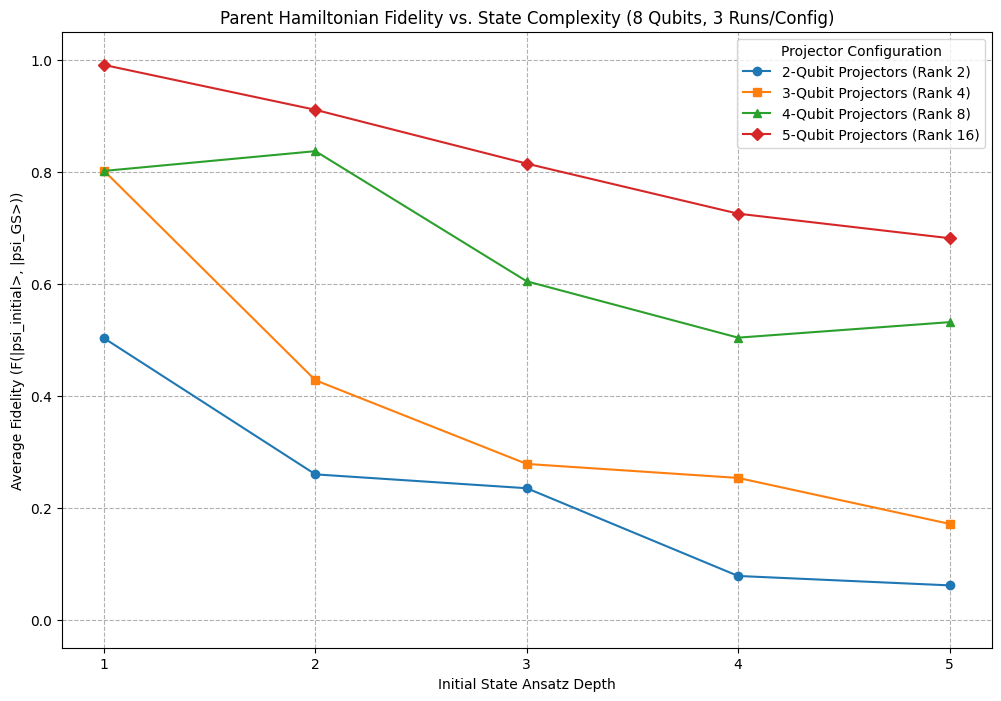

In [7]:
plt.figure(figsize=(12, 8))
markers = ['o', 's', '^', 'D', 'v', '<', '>'] # Different markers for each line

for i, (proj_size, avg_fidelities) in enumerate(results_by_proj_size.items()):
    # Determine rank and reps for the label
    rank = 2**(proj_size - 1)
    
    valid_indices = ~np.isnan(avg_fidelities)
    plot_depths = np.array(ansatz_depths)[valid_indices]
    plot_fidelities = np.array(avg_fidelities)[valid_indices]
    
    if len(plot_depths) > 0: 
        plt.plot(plot_depths, plot_fidelities, 
                 marker=markers[i % len(markers)], linestyle='-', 
                 label=f'{proj_size}-Qubit Projectors (Rank {rank})')

plt.xlabel("Initial State Ansatz Depth")
plt.ylabel("Average Fidelity (F(|psi_initial>, |psi_GS>))")
plt.title(f"Parent Hamiltonian Fidelity vs. State Complexity ({NUM_QUBITS} Qubits, {NUM_RUNS_PER_CONFIG} Runs/Config)")
plt.xticks(ansatz_depths)
plt.ylim(-0.05, 1.05)
plt.grid(True, which='both', linestyle='--')
plt.legend(title="Projector Configuration")
plt.show()